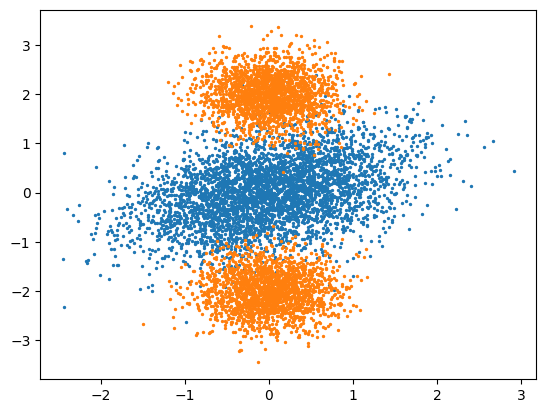

i: 0, loss: 0.9655913162236983
i: 1, loss: 0.439827214019181
i: 2, loss: 0.15310679699830002
i: 3, loss: 0.04660026137109955
i: 4, loss: 0.11554511331701181
i: 5, loss: 0.15933326179293955
i: 6, loss: 0.11150852185334549
i: 7, loss: 0.05231828282422719
i: 8, loss: 0.03370115157784424
i: 9, loss: 0.04506747800020793
i: 10, loss: 0.05914912763739961
i: 11, loss: 0.06444341070680262
i: 12, loss: 0.05788582551726719
i: 13, loss: 0.049230028860949245
i: 14, loss: 0.04045421678148247
i: 15, loss: 0.03629891975648184
i: 16, loss: 0.03472515929741287
i: 17, loss: 0.03365335629299043
i: 18, loss: 0.03176019241119831
i: 19, loss: 0.02979309988468884
i: 20, loss: 0.02930610100971194
i: 21, loss: 0.030148259704176672
i: 22, loss: 0.030829894242873565
i: 23, loss: 0.029056680221400413
i: 24, loss: 0.026321446767628355
i: 25, loss: 0.02371442525546174
i: 26, loss: 0.022802625198262032
i: 27, loss: 0.023257509224656876
i: 28, loss: 0.02456567282003348
i: 29, loss: 0.025806445969276795
i: 30, loss: 0.

In [1]:
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from fbs.dsb import ipf_loss, simulate_discrete_time

jax.config.update("jax_enable_x64", True)

# Config
nsamples = 2000
niters = 200
key = jax.random.PRNGKey(666)
nn_float = jnp.float64
nn_param_init = nn.initializers.xavier_normal()

dt = 0.01
nsteps = 50
T = nsteps * dt
ts = jnp.linspace(0, T, nsteps + 1)


# Toy data
def sample_x0s(_key):
    _, _subkey = jax.random.split(_key)
    ss = jax.random.normal(_subkey, (nsamples, 2)) @ jnp.linalg.cholesky(jnp.array([[0.5, 0.2],
                                                                                    [0.2, 0.5]]))
    return jnp.array([0., 0.]) + ss


def sample_xTs(_key):
    _key, _subkey = jax.random.split(_key)
    _c1 = jnp.array([0., 2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    _key, _subkey = jax.random.split(_key)
    _c2 = jnp.array([0., -2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    return jnp.concatenate([_c1, _c2], axis=0)


key, subkey = jax.random.split(key)
x0s = sample_x0s(subkey)
key, subkey = jax.random.split(key)
xTs = sample_xTs(subkey)
plt.scatter(x0s[:, 0], x0s[:, 1], s=2)
plt.scatter(xTs[:, 0], xTs[:, 1], s=2)
plt.show()


# Reference measure
def drift(x, _):
    return -0.5 * x

sigma = 1.


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param_fwd, _, nn_fwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, key=subkey)
key, subkey = jax.random.split(key)
init_param_bwd, _, nn_bwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, key=subkey)

schedule = optax.exponential_decay(1e-2, niters, 0.9)
optimiser = optax.adam(learning_rate=schedule)
f_param = init_param_fwd
b_param = init_param_bwd


# The first IPF iteration
def init_f(x, t, _): return x


@jax.jit
def optax_kernel_init(_b_param, _opt_state, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_fwd_loss)(_b_param, _, init_f, nn_bwd, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_fwd(_b_param, _opt_state, _f_param, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_fwd_loss)(_b_param, _f_param, nn_fwd, nn_bwd, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_bwd(_f_param, _opt_state, _b_param, _key):
    _key, _subkey = jax.random.split(_key)
    _xTs = sample_xTs(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_bwd_loss)(_f_param, _b_param, nn_fwd, nn_bwd, _xTs, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _f_param)
    _f_param = optax.apply_updates(_f_param, updates)
    return _f_param, _opt_state, _loss


opt_state = optimiser.init(init_param_bwd)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_init(b_param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

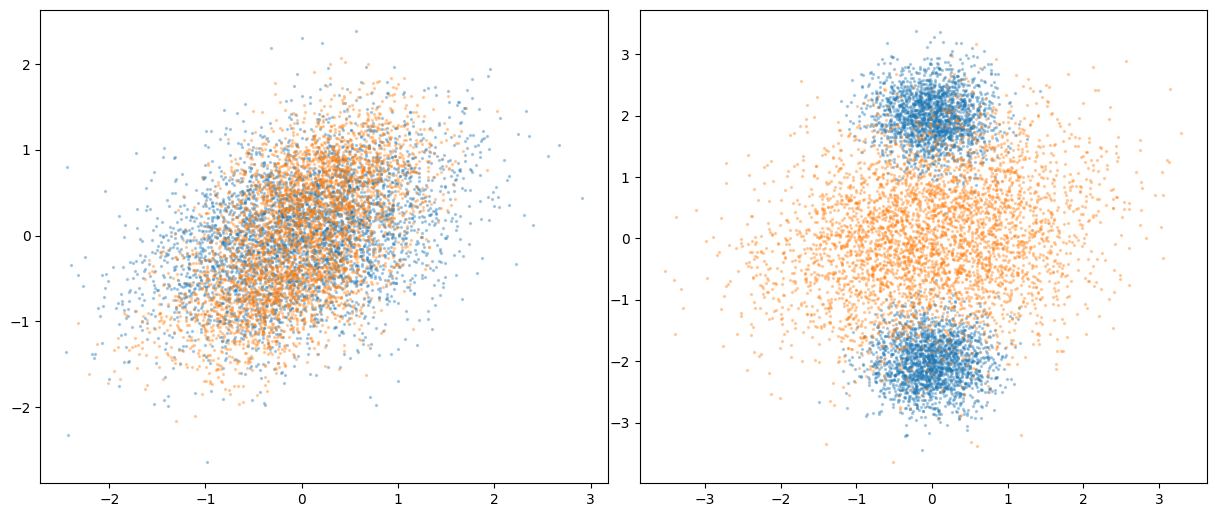

In [2]:
# Test if the reverse is learnt correctly
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(init_f, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [3]:
opt_state = optimiser.init(init_param_fwd)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 2.9601535122826923
i: 1, loss: 0.9288340758140282
i: 2, loss: 0.18718182014013832
i: 3, loss: 0.33709631120846506
i: 4, loss: 0.5390488092008885
i: 5, loss: 0.35061046009453534
i: 6, loss: 0.11574979846663123
i: 7, loss: 0.05771406857323049
i: 8, loss: 0.1249616523879838
i: 9, loss: 0.1892120059669333
i: 10, loss: 0.18659229745092637
i: 11, loss: 0.14140562670792256
i: 12, loss: 0.08533616109674462
i: 13, loss: 0.045453436568238796
i: 14, loss: 0.03763377641344055
i: 15, loss: 0.053184393393955726
i: 16, loss: 0.07276044080693862
i: 17, loss: 0.07920433825056113
i: 18, loss: 0.07007032460388823
i: 19, loss: 0.0537443050074827
i: 20, loss: 0.038057508593719896
i: 21, loss: 0.03146860945017682
i: 22, loss: 0.032875631339607116
i: 23, loss: 0.03753153166516442
i: 24, loss: 0.042487773827794055
i: 25, loss: 0.043706550378666574
i: 26, loss: 0.04167002414962854
i: 27, loss: 0.03480750120881832
i: 28, loss: 0.02767677694757109
i: 29, loss: 0.023640871467146364
i: 30, loss: 0.0249

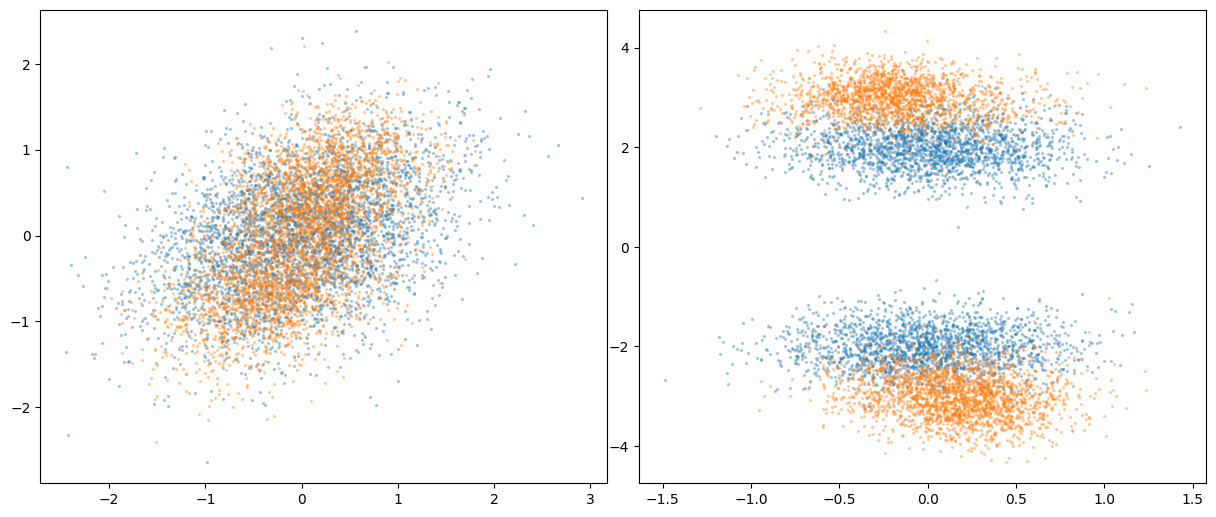

In [4]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [5]:
opt_state = optimiser.init(init_param_bwd)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.02939202643230536
i: 1, loss: 0.09239378134361036
i: 2, loss: 0.040393067159215756
i: 3, loss: 0.03446221673672658
i: 4, loss: 0.04601891501753926
i: 5, loss: 0.04693307365200235
i: 6, loss: 0.03232245464859755
i: 7, loss: 0.024070268646477325
i: 8, loss: 0.027294377695553006
i: 9, loss: 0.03236763971998391
i: 10, loss: 0.033308635694307046
i: 11, loss: 0.029658860343767714
i: 12, loss: 0.02521998400756633
i: 13, loss: 0.022653937929973705
i: 14, loss: 0.0232511876413732
i: 15, loss: 0.025954711445519463
i: 16, loss: 0.02734230996764097
i: 17, loss: 0.02502260437008514
i: 18, loss: 0.02185078112292492
i: 19, loss: 0.020252333100519673
i: 20, loss: 0.021325235321037514
i: 21, loss: 0.02315064717591377
i: 22, loss: 0.023759936412989256
i: 23, loss: 0.02284590639321362
i: 24, loss: 0.021373683899960493
i: 25, loss: 0.02024158647702908
i: 26, loss: 0.020355373429863148
i: 27, loss: 0.021224690074627753
i: 28, loss: 0.021803805484042788
i: 29, loss: 0.021246389207168943
i: 30,

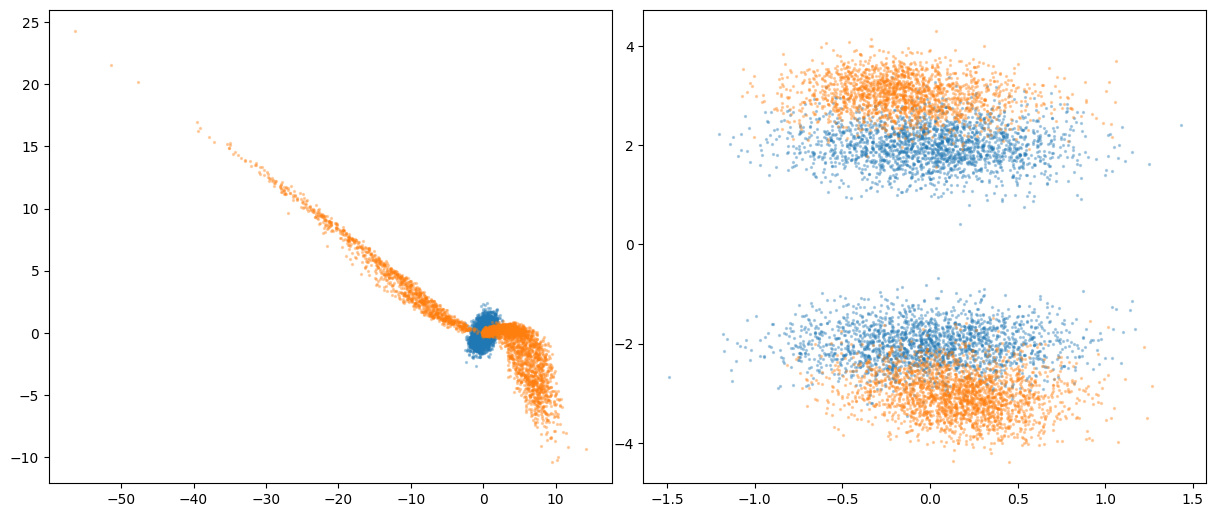

In [6]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()

In [7]:
opt_state = optimiser.init(init_param_fwd)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 0.021987762246624045
i: 1, loss: 0.6235366532251263
i: 2, loss: 0.052982773598132776
i: 3, loss: 0.12019469793520862
i: 4, loss: 0.293435527749389
i: 5, loss: 0.3169796905899988
i: 6, loss: 0.22213781038122757
i: 7, loss: 0.0967586699796791
i: 8, loss: 0.02493040472821801
i: 9, loss: 0.047819451399867145
i: 10, loss: 0.12222839786408303
i: 11, loss: 0.15251848046077715
i: 12, loss: 0.1143439360115335
i: 13, loss: 0.056077963249693136
i: 14, loss: 0.024079040356538628
i: 15, loss: 0.02976836475748732
i: 16, loss: 0.055552318979603756
i: 17, loss: 0.07716803403291199
i: 18, loss: 0.08036553143428243
i: 19, loss: 0.06399080611483499
i: 20, loss: 0.040205063155569015
i: 21, loss: 0.023478106933236625
i: 22, loss: 0.022809477653996907
i: 23, loss: 0.03447474880873114
i: 24, loss: 0.0458583351667137
i: 25, loss: 0.0468152596618881
i: 26, loss: 0.0374107889635301
i: 27, loss: 0.02599007128262966
i: 28, loss: 0.02122566470966334
i: 29, loss: 0.02324984632593488
i: 30, loss: 0.02832

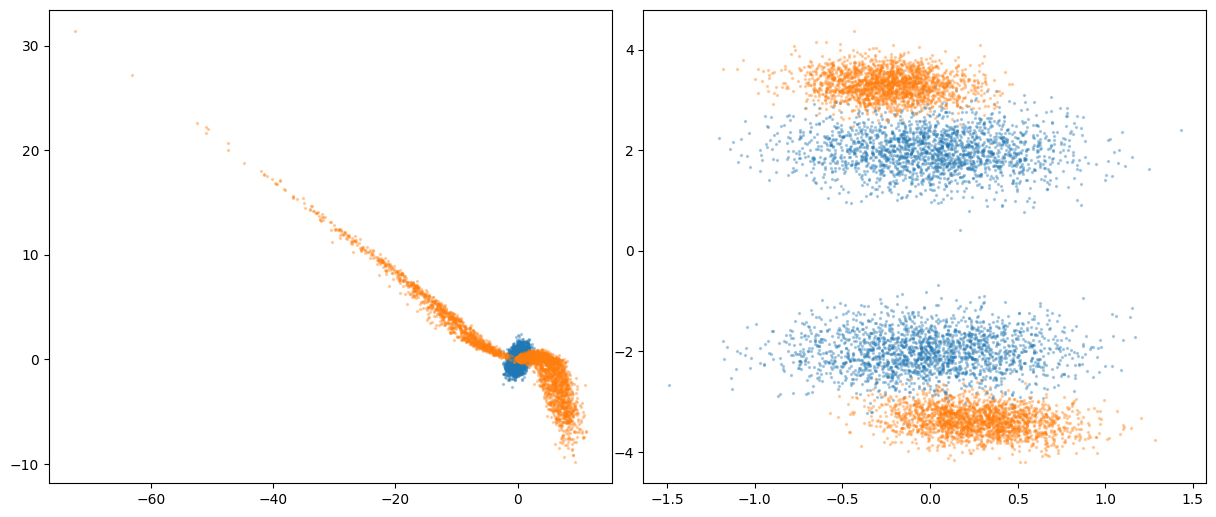

In [8]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2, alpha=0.3)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2, alpha=0.3)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2, alpha=0.3)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2, alpha=0.3)

plt.tight_layout(pad=0.1)
plt.show()